In [1]:
# Dependencies

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sn

import quandl
from config import quandl_api_key

from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.stats import linregress
from scipy.stats import zscore
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
all_dataframes = []

In [3]:
# API Calls to Quandl

# Treasury Yield Curve
try:
    treas_ylds = quandl.get("USTREASURY/YIELD", authtoken=quandl_api_key)
    treas_ylds.to_csv("quandl_data/treas_yld_curve.csv")
    
except Exception as e:
    print(e)
    
# S&P 500 Monthly Dividend Yield
try:   
    sp500_div_yld = quandl.get("MULTPL/SP500_DIV_YIELD_MONTH", authtoken=quandl_api_key)
    sp500_div_yld.to_csv("quandl_data/sp500_div_yld.csv")
    
except Exception as e:
    print(e)   
    
# S&P 500 2-Month Futures
try:  
    sp500_1m = quandl.get("CHRIS/CME_ES2", authtoken=quandl_api_key) 
    sp500_1m.to_csv("quandl_data/sp500_2m.csv")

except Exception as e:
    print(e)
    
# TED Spread (3-Month LIBOR - 3-Month Treasury)
try:  
    ted_spread = quandl.get("FRED/TEDRATE", authtoken=quandl_api_key) 
    ted_spread.to_csv("quandl_data/ted_spread.csv")

except Exception as e:
    print(e)

In [4]:
def add_to_df_list(df):
    if f"{df}" not in all_dataframes:
        all_dataframes.append(f"{df}")

In [5]:
def df_returns(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d"), add_text="% Ret"):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)

    returns = sort_dates_df[col_titles[0]] / sort_dates_df[col_titles[0]].shift(1)-1

    perc_ret_df = pd.DataFrame({f"{col_titles[0]} {add_text}": round(returns * 100, 2)})

    for title in col_titles[1:]:
        returns = sort_dates_df[title] / sort_dates_df[title].shift(1)-1
        perc_ret_df[f"{title} {add_text}"] = round(returns * 100, 2)
    
    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf], 0)
    return perc_ret_df

In [6]:
def df_total_returns(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d"), add_text="% Tot_Ret"):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)
    null_list = list(sort_dates_df.reset_index().ne(0).idxmax())
    null_list.pop(0)

    returns = (sort_dates_df[col_titles[0]] - sort_dates_df[col_titles[0]][null_list[0]]) / sort_dates_df[col_titles[0]][null_list[0]]

    perc_ret_df = pd.DataFrame({f"{col_titles[0]} {add_text}": round(returns * 100, 2)})

    for title, num in zip(col_titles[1:], null_list[1:]):
        returns = (sort_dates_df[title] - sort_dates_df[title][num]) / sort_dates_df[title][num]
        perc_ret_df[f"{title} {add_text}"] = round(returns * 100, 2)

    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf, -100], 0)
    return perc_ret_df

In [7]:
def df_corr_analysis(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)

    perc_ret_df = pd.DataFrame({f"{col_titles[0]}": sort_dates_df[col_titles[0]]})

    for title in col_titles[1:]:
        correlation = sort_dates_df[col_titles[0]].rolling(100).corr(sort_dates_df[title])
        perc_ret_df[f"{col_titles[0]} corr {title}"] = correlation

    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf], 0)

    return perc_ret_df

In [8]:
def df_datefilter(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df["Date"] >= begin_date) & (original_df["Date"] <= end_date)]

    return sort_dates_df

In [9]:
# Merge All Data on Index "Date"

merge_sp500wdiv = sp500_1m[["Settle", "Open", "High", "Low", "Last"]].join(sp500_div_yld, how="outer").rename(columns={"Settle": "SP500", "Value": "Div Yld"})
merge_ted = merge_sp500wdiv.join(ted_spread, how="outer").rename(columns={"Value": "TED"})
merge_treas_ylds = merge_ted.join(treas_ylds, how="outer")

raw_df = merge_treas_ylds.copy()
raw_df

,SP500,Open,High,Low,Last,Div Yld,TED,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,,,,,,,,
1871-01-31,NaN,NaN,NaN,NaN,NaN,5.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-02-28,NaN,NaN,NaN,NaN,NaN,5.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-03-31,NaN,NaN,NaN,NaN,NaN,5.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-04-30,NaN,NaN,NaN,NaN,NaN,5.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871-05-31,NaN,NaN,NaN,NaN,NaN,5.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-12,3023.75,3000.75,3076.75,2971.00,3024.5,NaN,NaN,0.14,0.15,0.16,0.18,0.18,0.19,0.22,0.33,0.54,0.71,1.24,1.45
2020-06-15,3062.00,2983.25,3068.25,2923.75,3065.5,NaN,NaN,0.15,0.16,0.18,0.19,0.17,0.19,0.22,0.33,0.54,0.71,1.24,1.45
2020-06-16,3118.25,3065.25,3156.25,3060.25,3116.0,NaN,NaN,0.14,0.15,0.17,0.19,0.18,0.21,0.23,0.34,0.56,0.75,1.31,1.54


In [10]:
filtered_df = raw_df[raw_df["SP500"].notna()].copy()
filtered_df = filtered_df.drop(columns=["Open", "High", "Low", "Last", "1 MO", "2 MO", "3 YR", "20 YR", "30 YR"])
filtered_df = filtered_df.loc[(filtered_df.index >= "1990-01-30")]
#filtered_df

In [11]:
#Calculate Daily Dividend Yield from the monthly value

div_yield_list = []
dollar_yield_list = []

dollar_yield = 0

for index, row in filtered_df.iterrows():
    price_row = row["SP500"]
    yield_row = row["Div Yld"]
    if yield_row > 0:
        div_yield_list.append(round(yield_row, 2))
        current_yield = yield_row
        dollar_yield = (current_yield / 100) * price_row
        dollar_yield_list.append(round(dollar_yield, 2))
    else:
        percent_yield = dollar_yield / price_row *100
        div_yield_list.append(round(percent_yield, 2))
    
print(len(div_yield_list))   

filtered_df["Div Yld"] = div_yield_list

starter_df = filtered_df.copy()
add_to_df_list("starter_df")
starter_df

5796


,SP500,Div Yld,TED,3 MO,6 MO,1 YR,2 YR,5 YR,7 YR,10 YR
Date,,,,,,,,,,
1997-09-09,944.00,0.00,0.70,5.16,5.35,5.60,5.98,6.24,6.33,6.34
1997-09-10,925.00,0.00,0.74,5.11,5.35,5.61,6.00,6.26,6.36,6.37
1997-09-11,918.25,0.00,0.72,5.13,5.36,5.59,6.00,6.27,6.38,6.39
1997-09-12,933.75,0.00,0.75,5.10,5.32,5.54,5.93,6.17,6.28,6.29
1997-09-15,931.50,0.00,0.72,5.08,5.31,5.54,5.93,6.17,6.28,6.28
...,...,...,...,...,...,...,...,...,...,...
2020-06-11,2999.50,1.98,NaN,0.17,0.18,0.19,0.19,0.32,0.51,0.66
2020-06-12,3023.75,1.96,NaN,0.16,0.18,0.18,0.19,0.33,0.54,0.71
2020-06-15,3062.00,1.94,NaN,0.18,0.19,0.17,0.19,0.33,0.54,0.71


In [12]:
returns_df = df_returns(starter_df)
add_to_df_list("returns_df")
returns_df

,SP500 % Ret,Div Yld % Ret,TED % Ret,3 MO % Ret,6 MO % Ret,1 YR % Ret,2 YR % Ret,5 YR % Ret,7 YR % Ret,10 YR % Ret
Date,,,,,,,,,,
1997-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,-2.01,NaN,5.71,-0.97,0.00,0.18,0.33,0.32,0.47,0.47
1997-09-11,-0.73,NaN,-2.70,0.39,0.19,-0.36,0.00,0.16,0.31,0.31
1997-09-12,1.69,NaN,4.17,-0.58,-0.75,-0.89,-1.17,-1.59,-1.57,-1.56
1997-09-15,-0.24,NaN,-4.00,-0.39,-0.19,0.00,0.00,0.00,0.00,-0.16
...,...,...,...,...,...,...,...,...,...,...
2020-06-10,-0.59,0.54,25.00,-10.53,0.00,-5.26,-15.00,-17.50,-13.85,-10.71
2020-06-11,-5.54,5.88,NaN,0.00,-5.26,5.56,11.76,-3.03,-8.93,-12.00
2020-06-12,0.81,-1.01,NaN,-5.88,0.00,-5.26,0.00,3.12,5.88,7.58


In [13]:
tot_returns_df = df_total_returns(starter_df)
add_to_df_list("tot_returns_df")
tot_returns_df

,SP500 % Tot_Ret,Div Yld % Tot_Ret,TED % Tot_Ret,3 MO % Tot_Ret,6 MO % Tot_Ret,1 YR % Tot_Ret,2 YR % Tot_Ret,5 YR % Tot_Ret,7 YR % Tot_Ret,10 YR % Tot_Ret
Date,,,,,,,,,,
1997-09-09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1997-09-10,-2.01,0.00,5.71,-0.97,0.00,0.18,0.33,0.32,0.47,0.47
1997-09-11,-2.73,0.00,2.86,-0.58,0.19,-0.18,0.33,0.48,0.79,0.79
1997-09-12,-1.09,0.00,7.14,-1.16,-0.56,-1.07,-0.84,-1.12,-0.79,-0.79
1997-09-15,-1.32,0.00,2.86,-1.55,-0.75,-1.07,-0.84,-1.12,-0.79,-0.95
...,...,...,...,...,...,...,...,...,...,...
2020-06-10,236.39,14.02,-78.57,-96.71,-96.45,-96.79,-97.16,-94.71,-91.15,-88.17
2020-06-11,217.74,20.73,NaN,-96.71,-96.64,-96.61,-96.82,-94.87,-91.94,-89.59
2020-06-12,220.31,19.51,NaN,-96.90,-96.64,-96.79,-96.82,-94.71,-91.47,-88.80


In [14]:
spreads_df = pd.DataFrame({
    "6Mo - 3Mo": starter_df["6 MO"] - starter_df["3 MO"],
    "1Yr - 3Mo": starter_df["1 YR"] - starter_df["3 MO"],
    "1Yr - 6Mo": starter_df["1 YR"] - starter_df["6 MO"],
    "2Yr - 3Mo": starter_df["2 YR"] - starter_df["3 MO"],
    "2Yr - 6Mo": starter_df["2 YR"] - starter_df["6 MO"],
    "2Yr - 1Yr": starter_df["2 YR"] - starter_df["1 YR"],
    "5Yr - 2Yr": starter_df["5 YR"] - starter_df["2 YR"],
    "7Yr - 2Yr": starter_df["7 YR"] - starter_df["2 YR"],
    "7Yr - 5Yr": starter_df["7 YR"] - starter_df["5 YR"],
    "10Yr - 2Yr": starter_df["10 YR"] - starter_df["2 YR"],
    "10Yr - 5Yr": starter_df["10 YR"] - starter_df["5 YR"],
    "10Yr - 7Yr": starter_df["10 YR"] - starter_df["7 YR"],
})

add_to_df_list("spreads_df")
spreads_df

,6Mo - 3Mo,1Yr - 3Mo,1Yr - 6Mo,2Yr - 3Mo,2Yr - 6Mo,2Yr - 1Yr,5Yr - 2Yr,7Yr - 2Yr,7Yr - 5Yr,10Yr - 2Yr,10Yr - 5Yr,10Yr - 7Yr
Date,,,,,,,,,,,,
1997-09-09,0.19,0.44,0.25,0.82,0.63,0.38,0.26,0.35,0.09,0.36,0.10,0.01
1997-09-10,0.24,0.50,0.26,0.89,0.65,0.39,0.26,0.36,0.10,0.37,0.11,0.01
1997-09-11,0.23,0.46,0.23,0.87,0.64,0.41,0.27,0.38,0.11,0.39,0.12,0.01
1997-09-12,0.22,0.44,0.22,0.83,0.61,0.39,0.24,0.35,0.11,0.36,0.12,0.01
1997-09-15,0.23,0.46,0.23,0.85,0.62,0.39,0.24,0.35,0.11,0.35,0.11,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-11,0.01,0.02,0.01,0.02,0.01,0.00,0.13,0.32,0.19,0.47,0.34,0.15
2020-06-12,0.02,0.02,0.00,0.03,0.01,0.01,0.14,0.35,0.21,0.52,0.38,0.17
2020-06-15,0.01,-0.01,-0.02,0.01,0.00,0.02,0.14,0.35,0.21,0.52,0.38,0.17


In [15]:
spread_ret_df = df_returns(spreads_df)
add_to_df_list("spread_ret_df")
spread_ret_df

,6Mo - 3Mo % Ret,1Yr - 3Mo % Ret,1Yr - 6Mo % Ret,2Yr - 3Mo % Ret,2Yr - 6Mo % Ret,2Yr - 1Yr % Ret,5Yr - 2Yr % Ret,7Yr - 2Yr % Ret,7Yr - 5Yr % Ret,10Yr - 2Yr % Ret,10Yr - 5Yr % Ret,10Yr - 7Yr % Ret
Date,,,,,,,,,,,,
1997-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,26.32,13.64,4.00,8.54,3.17,2.63,0.00,2.86,11.11,2.78,10.00,0.00
1997-09-11,-4.17,-8.00,-11.54,-2.25,-1.54,5.13,3.85,5.56,10.00,5.41,9.09,0.00
1997-09-12,-4.35,-4.35,-4.35,-4.60,-4.69,-4.88,-11.11,-7.89,0.00,-7.69,0.00,0.00
1997-09-15,4.55,4.55,4.55,2.41,1.64,0.00,0.00,0.00,0.00,-2.78,-8.33,-100.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,0.00,0.00,0.00,-100.00,-300.00,-200.00,-20.00,-13.33,-8.00,-9.37,-4.55,0.00
2020-06-11,-50.00,100.00,-200.00,0.00,-150.00,-100.00,-18.75,-17.95,-17.39,-18.97,-19.05,-21.05
2020-06-12,100.00,0.00,-100.00,50.00,0.00,0.00,7.69,9.38,10.53,10.64,11.76,13.33


In [16]:
spread_tot_ret_df = df_total_returns(spreads_df)
add_to_df_list("spread_tot_ret_df")
spread_tot_ret_df

,6Mo - 3Mo % Tot_Ret,1Yr - 3Mo % Tot_Ret,1Yr - 6Mo % Tot_Ret,2Yr - 3Mo % Tot_Ret,2Yr - 6Mo % Tot_Ret,2Yr - 1Yr % Tot_Ret,5Yr - 2Yr % Tot_Ret,7Yr - 2Yr % Tot_Ret,7Yr - 5Yr % Tot_Ret,10Yr - 2Yr % Tot_Ret,10Yr - 5Yr % Tot_Ret,10Yr - 7Yr % Tot_Ret
Date,,,,,,,,,,,,
1997-09-09,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
1997-09-10,26.32,13.64,4.0,8.54,3.17,2.63,0.00,2.86,11.11,2.78,10.0,0.0
1997-09-11,21.05,4.55,-8.0,6.10,1.59,7.89,3.85,8.57,22.22,8.33,20.0,0.0
1997-09-12,15.79,0.00,-12.0,1.22,-3.17,2.63,-7.69,0.00,22.22,0.00,20.0,0.0
1997-09-15,21.05,4.55,-8.0,3.66,-1.59,2.63,-7.69,0.00,22.22,-2.78,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,-89.47,-97.73,-104.0,0.00,-103.17,-102.63,-38.46,11.43,155.56,61.11,320.0,1800.0
2020-06-11,-94.74,-95.45,-96.0,-97.56,-98.41,0.00,-50.00,-8.57,111.11,30.56,240.0,1400.0
2020-06-12,-89.47,-95.45,0.0,-96.34,-98.41,-97.37,-46.15,0.00,133.33,44.44,280.0,1600.0


In [17]:
div_spreads_df = pd.DataFrame({
    "Div/6-3": starter_df["Div Yld"] / spreads_df["6Mo - 3Mo"],
    "Div/1-3": starter_df["Div Yld"] / spreads_df["1Yr - 3Mo"],
    "Div/1-6": starter_df["Div Yld"] / spreads_df["1Yr - 6Mo"],
    "Div/2-3": starter_df["Div Yld"] / spreads_df["2Yr - 3Mo"],
    "Div/2-6": starter_df["Div Yld"] / spreads_df["2Yr - 6Mo"],
    "Div/2-1": starter_df["Div Yld"] / spreads_df["2Yr - 1Yr"],
    "Div/5-2": starter_df["Div Yld"] / spreads_df["5Yr - 2Yr"],
    "Div/7-2": starter_df["Div Yld"] / spreads_df["7Yr - 2Yr"],
    "Div/7-5": starter_df["Div Yld"] / spreads_df["7Yr - 5Yr"],
    "Div/10-2": starter_df["Div Yld"] / spreads_df["10Yr - 2Yr"],
    "Div/10-5": starter_df["Div Yld"] / spreads_df["10Yr - 5Yr"],
    "Div/10-7": starter_df["Div Yld"] / spreads_df["10Yr - 7Yr"],
})

div_spreads_df = div_spreads_df.replace([np.inf, -np.inf], 0)
# print(div_spreads_df.isnull().sum())
# div_spreads_df.dropna(inplace=True)
# print(div_spreads_df.isnull().sum())
add_to_df_list("div_spreads_df")
div_spreads_df

,Div/6-3,Div/1-3,Div/1-6,Div/2-3,Div/2-6,Div/2-1,Div/5-2,Div/7-2,Div/7-5,Div/10-2,Div/10-5,Div/10-7
Date,,,,,,,,,,,,
1997-09-09,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-10,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-11,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-12,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-15,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-11,198.0,99.0,198.0,99.000000,198.0,0.000000,15.230769,6.187500,10.421053,4.212766,5.823529,13.200000
2020-06-12,98.0,98.0,0.0,65.333333,196.0,196.000000,14.000000,5.600000,9.333333,3.769231,5.157895,11.529412
2020-06-15,194.0,-194.0,-97.0,194.000000,0.0,97.000000,13.857143,5.542857,9.238095,3.730769,5.105263,11.411765


In [18]:
div_spread_ret_df = df_returns(div_spreads_df)
add_to_df_list("div_spread_ret_df")
div_spread_ret_df

,Div/6-3 % Ret,Div/1-3 % Ret,Div/1-6 % Ret,Div/2-3 % Ret,Div/2-6 % Ret,Div/2-1 % Ret,Div/5-2 % Ret,Div/7-2 % Ret,Div/7-5 % Ret,Div/10-2 % Ret,Div/10-5 % Ret,Div/10-7 % Ret
Date,,,,,,,,,,,,
1997-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,0.00,0.00,0.00,-100.00,-150.27,-200.54,25.67,16.00,9.28,10.94,5.33,0.54
2020-06-11,111.76,-47.06,-205.88,0.00,-311.76,-100.00,30.32,29.04,28.17,30.66,30.80,34.12
2020-06-12,-50.51,-1.01,-100.00,-34.01,-1.01,0.00,-8.08,-9.49,-10.44,-10.53,-11.43,-12.66


In [19]:
div_spread_tot_ret_df = df_total_returns(div_spreads_df)
add_to_df_list("div_spread_tot_ret_df")
div_spread_tot_ret_df

,Div/6-3 % Tot_Ret,Div/1-3 % Tot_Ret,Div/1-6 % Tot_Ret,Div/2-3 % Tot_Ret,Div/2-6 % Tot_Ret,Div/2-1 % Tot_Ret,Div/5-2 % Tot_Ret,Div/7-2 % Tot_Ret,Div/7-5 % Tot_Ret,Div/10-2 % Tot_Ret,Div/10-5 % Tot_Ret,Div/10-7 % Tot_Ret
Date,,,,,,,,,,,,
1997-09-09,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
1997-09-10,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
1997-09-11,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
1997-09-12,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
1997-09-15,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,1154.27,4575.0,-2266.46,0.00,-3064.63,-3862.80,42.53,-9.37,-45.47,-37.09,-67.42,NaN
2020-06-11,2556.10,2375.0,2193.90,4367.07,6178.05,0.00,85.74,16.96,-30.10,-17.80,-57.39,NaN
2020-06-12,1214.63,2350.0,0.00,2847.97,6114.63,3843.90,70.73,5.85,-37.40,-26.45,-62.26,NaN


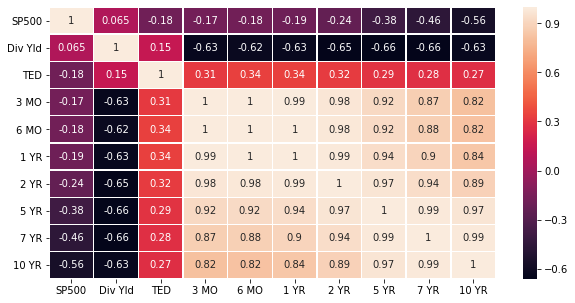

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(starter_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

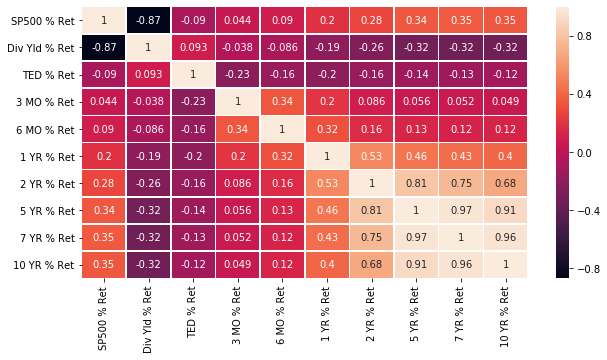

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(returns_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

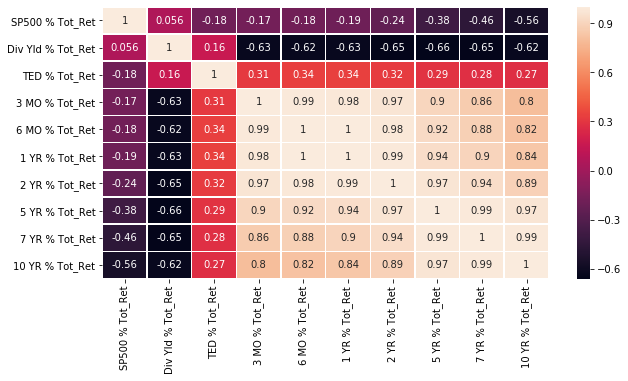

In [22]:
fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(tot_returns_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

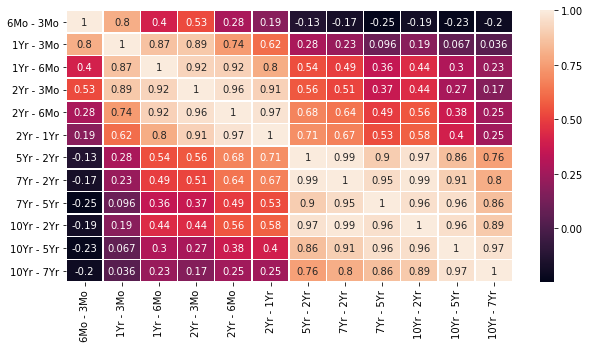

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(spreads_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

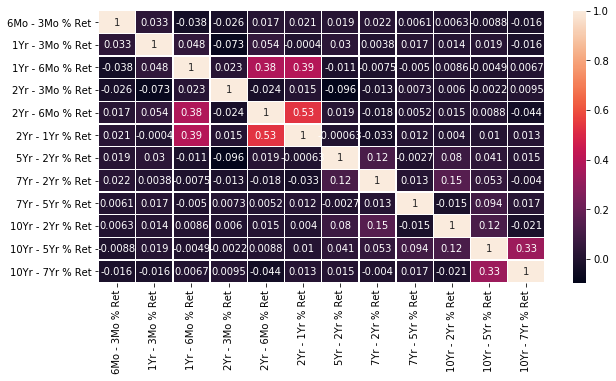

In [24]:
fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(spread_ret_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

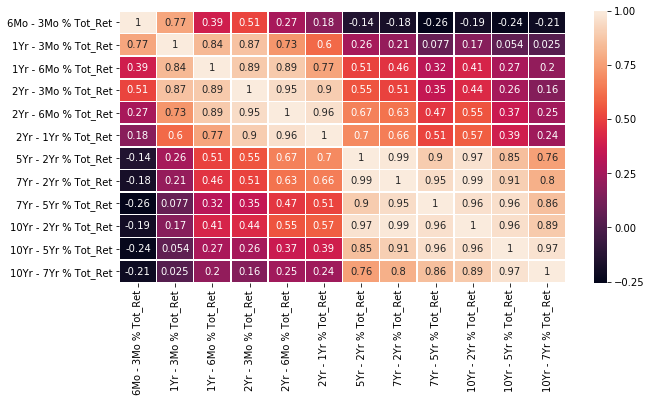

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(spread_tot_ret_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

In [26]:
final_df = starter_df[["SP500"]].join(spread_ret_df, how="outer")
final_df

print(final_df.isnull().sum())
final_df.dropna(inplace=True)
print(final_df.isnull().sum())
final_df

SP500                 0
6Mo - 3Mo % Ret     233
1Yr - 3Mo % Ret     224
1Yr - 6Mo % Ret     239
2Yr - 3Mo % Ret     215
2Yr - 6Mo % Ret     211
2Yr - 1Yr % Ret     214
5Yr - 2Yr % Ret     234
7Yr - 2Yr % Ret     210
7Yr - 5Yr % Ret     307
10Yr - 2Yr % Ret    212
10Yr - 5Yr % Ret    219
10Yr - 7Yr % Ret    227
dtype: int64
SP500               0
6Mo - 3Mo % Ret     0
1Yr - 3Mo % Ret     0
1Yr - 6Mo % Ret     0
2Yr - 3Mo % Ret     0
2Yr - 6Mo % Ret     0
2Yr - 1Yr % Ret     0
5Yr - 2Yr % Ret     0
7Yr - 2Yr % Ret     0
7Yr - 5Yr % Ret     0
10Yr - 2Yr % Ret    0
10Yr - 5Yr % Ret    0
10Yr - 7Yr % Ret    0
dtype: int64


,SP500,6Mo - 3Mo % Ret,1Yr - 3Mo % Ret,1Yr - 6Mo % Ret,2Yr - 3Mo % Ret,2Yr - 6Mo % Ret,2Yr - 1Yr % Ret,5Yr - 2Yr % Ret,7Yr - 2Yr % Ret,7Yr - 5Yr % Ret,10Yr - 2Yr % Ret,10Yr - 5Yr % Ret,10Yr - 7Yr % Ret
Date,,,,,,,,,,,,,
1997-09-10,925.00,26.32,13.64,4.00,8.54,3.17,2.63,0.00,2.86,11.11,2.78,10.00,0.00
1997-09-11,918.25,-4.17,-8.00,-11.54,-2.25,-1.54,5.13,3.85,5.56,10.00,5.41,9.09,0.00
1997-09-12,933.75,-4.35,-4.35,-4.35,-4.60,-4.69,-4.88,-11.11,-7.89,0.00,-7.69,0.00,0.00
1997-09-15,931.50,4.55,4.55,4.55,2.41,1.64,0.00,0.00,0.00,0.00,-2.78,-8.33,-100.00
1997-09-16,956.00,-17.39,-17.39,-17.39,-15.29,-14.52,-12.82,-20.83,-20.00,-18.18,-14.29,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,3175.50,0.00,0.00,0.00,-100.00,-300.00,-200.00,-20.00,-13.33,-8.00,-9.37,-4.55,0.00
2020-06-11,2999.50,-50.00,100.00,-200.00,0.00,-150.00,-100.00,-18.75,-17.95,-17.39,-18.97,-19.05,-21.05
2020-06-12,3023.75,100.00,0.00,-100.00,50.00,0.00,0.00,7.69,9.38,10.53,10.64,11.76,13.33


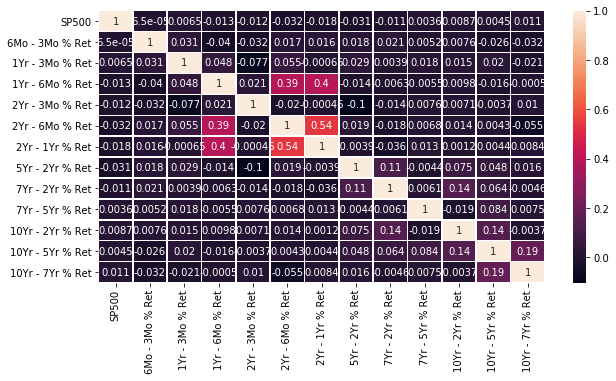

In [27]:



fig = plt.figure(figsize=(10, 5))
ax = sn.heatmap(final_df.corr(), annot=True, linewidth=0.5)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.xaxis.set_label_position("top")
#fig.tight_layout()
plt.show()

In [28]:
corr_df = df_corr_analysis(final_df)
add_to_df_list("corr_df")
corr_df

print(final_df.isnull().sum())
corr_df.dropna(inplace=True)
print(final_df.isnull().sum())
corr_df

SP500               0
6Mo - 3Mo % Ret     0
1Yr - 3Mo % Ret     0
1Yr - 6Mo % Ret     0
2Yr - 3Mo % Ret     0
2Yr - 6Mo % Ret     0
2Yr - 1Yr % Ret     0
5Yr - 2Yr % Ret     0
7Yr - 2Yr % Ret     0
7Yr - 5Yr % Ret     0
10Yr - 2Yr % Ret    0
10Yr - 5Yr % Ret    0
10Yr - 7Yr % Ret    0
dtype: int64
SP500               0
6Mo - 3Mo % Ret     0
1Yr - 3Mo % Ret     0
1Yr - 6Mo % Ret     0
2Yr - 3Mo % Ret     0
2Yr - 6Mo % Ret     0
2Yr - 1Yr % Ret     0
5Yr - 2Yr % Ret     0
7Yr - 2Yr % Ret     0
7Yr - 5Yr % Ret     0
10Yr - 2Yr % Ret    0
10Yr - 5Yr % Ret    0
10Yr - 7Yr % Ret    0
dtype: int64


,SP500,SP500 corr 6Mo - 3Mo % Ret,SP500 corr 1Yr - 3Mo % Ret,SP500 corr 1Yr - 6Mo % Ret,SP500 corr 2Yr - 3Mo % Ret,SP500 corr 2Yr - 6Mo % Ret,SP500 corr 2Yr - 1Yr % Ret,SP500 corr 5Yr - 2Yr % Ret,SP500 corr 7Yr - 2Yr % Ret,SP500 corr 7Yr - 5Yr % Ret,SP500 corr 10Yr - 2Yr % Ret,SP500 corr 10Yr - 5Yr % Ret,SP500 corr 10Yr - 7Yr % Ret
Date,,,,,,,,,,,,,
1998-02-19,1041.00,0.066375,-0.151284,-0.027983,0.135100,0.172069,0.142002,-0.045314,-0.049833,-0.062361,-0.075274,-0.094695,-0.155778
1998-02-20,1048.25,0.065445,-0.139698,-0.060373,0.151063,0.216672,0.146235,-0.044914,-0.054516,-0.067551,-0.061876,-0.068745,-0.156395
1998-02-23,1051.25,0.023017,-0.139516,-0.057803,0.134562,0.292411,0.156640,-0.053712,-0.055914,-0.059672,-0.066059,-0.066308,-0.145087
1998-02-24,1043.50,-0.066457,-0.108419,-0.030832,0.186147,0.306592,0.131447,-0.035437,-0.045276,-0.061374,-0.071439,-0.099478,-0.119547
1998-02-25,1057.75,-0.092260,-0.109867,-0.032544,0.158990,0.292192,0.175185,-0.077650,-0.070355,-0.048143,-0.113777,-0.105980,-0.126092
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,3175.50,0.084034,-0.040482,0.176046,-0.147328,-0.152759,-0.063336,-0.279230,-0.094722,-0.059669,-0.105324,-0.070967,-0.002962
2020-06-11,2999.50,0.077681,-0.030871,0.174276,-0.144613,-0.155059,-0.058220,-0.283651,-0.099036,-0.065949,-0.110951,-0.076917,-0.006975
2020-06-12,3023.75,0.071418,-0.031122,0.177889,-0.169741,-0.157124,-0.042773,-0.287329,-0.102113,-0.069928,-0.112977,-0.077750,-0.006707


In [29]:
z_score_aaa = corr_df.apply(zscore).copy()
z_score_aaa

,SP500,SP500 corr 6Mo - 3Mo % Ret,SP500 corr 1Yr - 3Mo % Ret,SP500 corr 1Yr - 6Mo % Ret,SP500 corr 2Yr - 3Mo % Ret,SP500 corr 2Yr - 6Mo % Ret,SP500 corr 2Yr - 1Yr % Ret,SP500 corr 5Yr - 2Yr % Ret,SP500 corr 7Yr - 2Yr % Ret,SP500 corr 7Yr - 5Yr % Ret,SP500 corr 10Yr - 2Yr % Ret,SP500 corr 10Yr - 5Yr % Ret,SP500 corr 10Yr - 7Yr % Ret
Date,,,,,,,,,,,,,
1998-02-19,-0.897049,0.663820,-1.974690,-0.595879,0.967657,1.459048,1.193755,-0.711724,-0.717181,-0.634909,-0.802266,-0.677667,-1.478067
1998-02-20,-0.884907,0.654074,-1.839509,-0.995221,1.127885,1.902331,1.237370,-0.707534,-0.767331,-0.691792,-0.666941,-0.434234,-1.484530
1998-02-23,-0.879884,0.209590,-1.837389,-0.963539,0.962256,2.655046,1.344554,-0.799683,-0.782299,-0.605445,-0.709198,-0.411373,-1.366068
1998-02-24,-0.892862,-0.727748,-1.474593,-0.631001,1.480031,2.795979,1.085027,-0.608265,-0.668378,-0.624093,-0.763529,-0.722533,-1.098501
1998-02-25,-0.868999,-0.998054,-1.491490,-0.652115,1.207444,2.652874,1.535593,-1.050425,-0.936955,-0.479086,-1.191158,-0.783527,-1.167074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-10,2.677441,0.848818,-0.682002,1.919653,-1.867168,-1.769207,-0.921536,-3.161910,-1.197905,-0.605407,-1.105782,-0.455080,0.122877
2020-06-11,2.382707,0.782257,-0.569876,1.897828,-1.839915,-1.792066,-0.868828,-3.208212,-1.244099,-0.674234,-1.162610,-0.510892,0.080836
2020-06-12,2.423317,0.716644,-0.572802,1.942377,-2.092135,-1.812583,-0.709706,-3.246737,-1.277049,-0.717842,-1.183075,-0.518713,0.083642


In [30]:
z_score_aaa = z_score_aaa.reset_index()
z_score_aaa

,Date,SP500,SP500 corr 6Mo - 3Mo % Ret,SP500 corr 1Yr - 3Mo % Ret,SP500 corr 1Yr - 6Mo % Ret,SP500 corr 2Yr - 3Mo % Ret,SP500 corr 2Yr - 6Mo % Ret,SP500 corr 2Yr - 1Yr % Ret,SP500 corr 5Yr - 2Yr % Ret,SP500 corr 7Yr - 2Yr % Ret,SP500 corr 7Yr - 5Yr % Ret,SP500 corr 10Yr - 2Yr % Ret,SP500 corr 10Yr - 5Yr % Ret,SP500 corr 10Yr - 7Yr % Ret
0,1998-02-19,-0.897049,0.663820,-1.974690,-0.595879,0.967657,1.459048,1.193755,-0.711724,-0.717181,-0.634909,-0.802266,-0.677667,-1.478067
1,1998-02-20,-0.884907,0.654074,-1.839509,-0.995221,1.127885,1.902331,1.237370,-0.707534,-0.767331,-0.691792,-0.666941,-0.434234,-1.484530
2,1998-02-23,-0.879884,0.209590,-1.837389,-0.963539,0.962256,2.655046,1.344554,-0.799683,-0.782299,-0.605445,-0.709198,-0.411373,-1.366068
3,1998-02-24,-0.892862,-0.727748,-1.474593,-0.631001,1.480031,2.795979,1.085027,-0.608265,-0.668378,-0.624093,-0.763529,-0.722533,-1.098501
4,1998-02-25,-0.868999,-0.998054,-1.491490,-0.652115,1.207444,2.652874,1.535593,-1.050425,-0.936955,-0.479086,-1.191158,-0.783527,-1.167074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,2020-06-10,2.677441,0.848818,-0.682002,1.919653,-1.867168,-1.769207,-0.921536,-3.161910,-1.197905,-0.605407,-1.105782,-0.455080,0.122877
5276,2020-06-11,2.382707,0.782257,-0.569876,1.897828,-1.839915,-1.792066,-0.868828,-3.208212,-1.244099,-0.674234,-1.162610,-0.510892,0.080836
5277,2020-06-12,2.423317,0.716644,-0.572802,1.942377,-2.092135,-1.812583,-0.709706,-3.246737,-1.277049,-0.717842,-1.183075,-0.518713,0.083642
5278,2020-06-15,2.487371,0.746697,-0.568142,1.928478,-2.174666,-1.747435,-0.382919,-3.237722,-1.180130,-0.581253,-1.102699,-0.458786,0.079668


In [31]:
corr_df = corr_df.reset_index()

In [32]:
aaa = df_datefilter(corr_df)
# aaa.loc[(aaa["SP500 corr 6Mo - 3Mo % Ret"] <= 0.15) & (aaa["SP500 corr 6Mo - 3Mo % Ret"] >= -0.17), "SP500 corr 6Mo - 3Mo % Ret"] = 0
aaa = df_datefilter(aaa)
# aaa = df_datefilter(aaa, begin_date="2015-06-11")
# aaa = df_datefilter(aaa, end_date="2015-06-11")
# aaa = df_datefilter(aaa, begin_date="2015-06-11", end_date="2020-06-11")
aaa

,Date,SP500,SP500 corr 6Mo - 3Mo % Ret,SP500 corr 1Yr - 3Mo % Ret,SP500 corr 1Yr - 6Mo % Ret,SP500 corr 2Yr - 3Mo % Ret,SP500 corr 2Yr - 6Mo % Ret,SP500 corr 2Yr - 1Yr % Ret,SP500 corr 5Yr - 2Yr % Ret,SP500 corr 7Yr - 2Yr % Ret,SP500 corr 7Yr - 5Yr % Ret,SP500 corr 10Yr - 2Yr % Ret,SP500 corr 10Yr - 5Yr % Ret,SP500 corr 10Yr - 7Yr % Ret
0,1998-02-19,1041.00,0.066375,-0.151284,-0.027983,0.135100,0.172069,0.142002,-0.045314,-0.049833,-0.062361,-0.075274,-0.094695,-0.155778
1,1998-02-20,1048.25,0.065445,-0.139698,-0.060373,0.151063,0.216672,0.146235,-0.044914,-0.054516,-0.067551,-0.061876,-0.068745,-0.156395
2,1998-02-23,1051.25,0.023017,-0.139516,-0.057803,0.134562,0.292411,0.156640,-0.053712,-0.055914,-0.059672,-0.066059,-0.066308,-0.145087
3,1998-02-24,1043.50,-0.066457,-0.108419,-0.030832,0.186147,0.306592,0.131447,-0.035437,-0.045276,-0.061374,-0.071439,-0.099478,-0.119547
4,1998-02-25,1057.75,-0.092260,-0.109867,-0.032544,0.158990,0.292192,0.175185,-0.077650,-0.070355,-0.048143,-0.113777,-0.105980,-0.126092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,2020-06-10,3175.50,0.084034,-0.040482,0.176046,-0.147328,-0.152759,-0.063336,-0.279230,-0.094722,-0.059669,-0.105324,-0.070967,-0.002962
5276,2020-06-11,2999.50,0.077681,-0.030871,0.174276,-0.144613,-0.155059,-0.058220,-0.283651,-0.099036,-0.065949,-0.110951,-0.076917,-0.006975
5277,2020-06-12,3023.75,0.071418,-0.031122,0.177889,-0.169741,-0.157124,-0.042773,-0.287329,-0.102113,-0.069928,-0.112977,-0.077750,-0.006707
5278,2020-06-15,3062.00,0.074286,-0.030722,0.176762,-0.177964,-0.150568,-0.011051,-0.286468,-0.093063,-0.057465,-0.105019,-0.071362,-0.007087


In [33]:
bbb = df_datefilter(corr_df)
bbb.loc[(bbb["SP500 corr 6Mo - 3Mo % Ret"] <= 0.15) & (bbb["SP500 corr 6Mo - 3Mo % Ret"] >= -0.17), "SP500 corr 6Mo - 3Mo % Ret"] = 0
bbb = df_datefilter(bbb)
# bbb = df_datefilter(bbb, begin_date="2015-06-11")
# bbb = df_datefilter(bbb, end_date="2015-06-11")
# bbb = df_datefilter(bbb, begin_date="2015-06-11", end_date="2020-06-11")
bbb

,Date,SP500,SP500 corr 6Mo - 3Mo % Ret,SP500 corr 1Yr - 3Mo % Ret,SP500 corr 1Yr - 6Mo % Ret,SP500 corr 2Yr - 3Mo % Ret,SP500 corr 2Yr - 6Mo % Ret,SP500 corr 2Yr - 1Yr % Ret,SP500 corr 5Yr - 2Yr % Ret,SP500 corr 7Yr - 2Yr % Ret,SP500 corr 7Yr - 5Yr % Ret,SP500 corr 10Yr - 2Yr % Ret,SP500 corr 10Yr - 5Yr % Ret,SP500 corr 10Yr - 7Yr % Ret
0,1998-02-19,1041.00,0.0,-0.151284,-0.027983,0.135100,0.172069,0.142002,-0.045314,-0.049833,-0.062361,-0.075274,-0.094695,-0.155778
1,1998-02-20,1048.25,0.0,-0.139698,-0.060373,0.151063,0.216672,0.146235,-0.044914,-0.054516,-0.067551,-0.061876,-0.068745,-0.156395
2,1998-02-23,1051.25,0.0,-0.139516,-0.057803,0.134562,0.292411,0.156640,-0.053712,-0.055914,-0.059672,-0.066059,-0.066308,-0.145087
3,1998-02-24,1043.50,0.0,-0.108419,-0.030832,0.186147,0.306592,0.131447,-0.035437,-0.045276,-0.061374,-0.071439,-0.099478,-0.119547
4,1998-02-25,1057.75,0.0,-0.109867,-0.032544,0.158990,0.292192,0.175185,-0.077650,-0.070355,-0.048143,-0.113777,-0.105980,-0.126092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,2020-06-10,3175.50,0.0,-0.040482,0.176046,-0.147328,-0.152759,-0.063336,-0.279230,-0.094722,-0.059669,-0.105324,-0.070967,-0.002962
5276,2020-06-11,2999.50,0.0,-0.030871,0.174276,-0.144613,-0.155059,-0.058220,-0.283651,-0.099036,-0.065949,-0.110951,-0.076917,-0.006975
5277,2020-06-12,3023.75,0.0,-0.031122,0.177889,-0.169741,-0.157124,-0.042773,-0.287329,-0.102113,-0.069928,-0.112977,-0.077750,-0.006707
5278,2020-06-15,3062.00,0.0,-0.030722,0.176762,-0.177964,-0.150568,-0.011051,-0.286468,-0.093063,-0.057465,-0.105019,-0.071362,-0.007087


In [34]:
master_df = aaa[["Date", "SP500", "SP500 corr 6Mo - 3Mo % Ret"]].copy()
# master_df = master_df.merge(bbb["SP500 corr 6Mo - 3Mo % Ret"], on="Date", how="outer")#.join(bbb, on="Date", how="outer")
master_df["Filtered SP500 corr 6Mo - 3Mo % Ret"] = bbb["SP500 corr 6Mo - 3Mo % Ret"].copy()
master_df.columns = ["Date", "SP500", "SP500corr", "filterSP500corr"]
master_df = master_df.merge(raw_df[["Open", "High", "Low", "Last"]], on="Date", how="inner")
master_df.to_csv("project_2_data_gary.csv", encoding='utf-8')
master_df

,Date,SP500,SP500corr,filterSP500corr,Open,High,Low,Last
0,1998-02-19,1041.00,0.066375,0.0,1045.00,1048.00,1039.50,1041.00
1,1998-02-20,1048.25,0.065445,0.0,1042.00,1049.00,1036.50,1048.25
2,1998-02-23,1051.25,0.023017,0.0,1051.50,1058.00,1044.75,1051.25
3,1998-02-24,1043.50,-0.066457,0.0,1053.00,1053.00,1041.50,1043.50
4,1998-02-25,1057.75,-0.092260,0.0,1043.00,1060.75,1042.50,1057.75
...,...,...,...,...,...,...,...,...
5275,2020-06-10,3175.50,0.084034,0.0,3194.25,3216.75,3168.75,3173.50
5276,2020-06-11,2999.50,0.077681,0.0,3173.00,3177.75,2985.25,3003.00
5277,2020-06-12,3023.75,0.071418,0.0,3000.75,3076.75,2971.00,3024.50
5278,2020-06-15,3062.00,0.074286,0.0,2983.25,3068.25,2923.75,3065.50


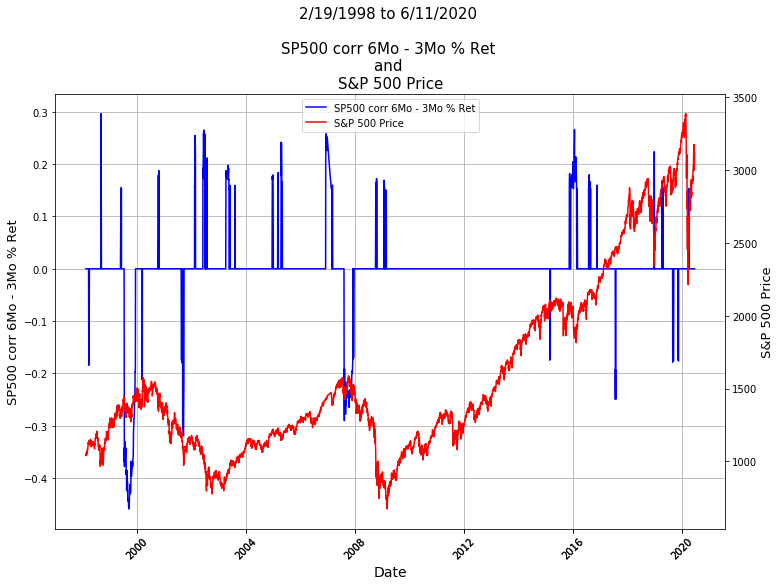

In [35]:
aaa = df_datefilter(corr_df)
aaa.loc[(aaa["SP500 corr 6Mo - 3Mo % Ret"] <= 0.15) & (aaa["SP500 corr 6Mo - 3Mo % Ret"] >= -0.17), \
        "SP500 corr 6Mo - 3Mo % Ret"] = 0
aaa = df_datefilter(aaa)
# aaa = df_datefilter(aaa, begin_date="2015-06-11")
# aaa = df_datefilter(aaa, end_date="2015-06-11")
# aaa = df_datefilter(aaa, begin_date="1998-09-08", end_date="1998-09-16")
aaa



fig8 = plt.figure(figsize=(12, 8))

ax1 = fig8.add_subplot(111)
line1 = ax1.plot(aaa["Date"], aaa["SP500 corr 6Mo - 3Mo % Ret"], "b-")
plt.xticks(rotation=45)
plt.ylabel("SP500 corr 6Mo - 3Mo % Ret", size=13)
plt.grid(alpha=1)

ax2 = fig8.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(aaa["Date"], aaa["SP500"], "r-")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.xticks(rotation=45)
plt.ylabel("S&P 500 Price", size=13)


ax1.legend((line1+line2), ("SP500 corr 6Mo - 3Mo % Ret", "S&P 500 Price"), loc="upper center")
plt.title("2/19/1998 to 6/11/2020 \n\nSP500 corr 6Mo - 3Mo % Ret \nand \nS&P 500 Price", size=15)
plt.xlabel("Date", size=14)

plt.show()

fig8.tight_layout()

In [36]:
final_div_df = starter_df[["SP500"]].join(div_spreads_df, how="outer")
final_div_df

# print(final_div_df.isnull().sum())
final_div_df.dropna(inplace=True)
# print(final_div_df.isnull().sum())
final_div_df

,SP500,Div/6-3,Div/1-3,Div/1-6,Div/2-3,Div/2-6,Div/2-1,Div/5-2,Div/7-2,Div/7-5,Div/10-2,Div/10-5,Div/10-7
Date,,,,,,,,,,,,,
1997-09-09,944.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-10,925.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-11,918.25,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-12,933.75,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997-09-16,956.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-11,2999.50,198.0,99.0,198.0,99.000000,198.0,0.000000,15.230769,6.187500,10.421053,4.212766,5.823529,13.200000
2020-06-12,3023.75,98.0,98.0,0.0,65.333333,196.0,196.000000,14.000000,5.600000,9.333333,3.769231,5.157895,11.529412
2020-06-15,3062.00,194.0,-194.0,-97.0,194.000000,0.0,97.000000,13.857143,5.542857,9.238095,3.730769,5.105263,11.411765


In [37]:
final_div_df = final_div_df.reset_index()

In [38]:
use_final_div_df = df_datefilter(final_div_df)
# use_final_div_df.loc[(use_final_div_df["Div/6-3"] <= 0.15) & (use_final_div_df["Div/6-3"] >= -0.17), \
#         "Div/6-3"] = 0
use_final_div_df = df_datefilter(use_final_div_df)
# use_final_div_df = df_datefilter(use_final_div_df, begin_date="2015-06-11")
# use_final_div_df = df_datefilter(use_final_div_df, end_date="2015-06-11")
# use_final_div_df = df_datefilter(use_final_div_df, begin_date="2016-02-19", end_date="2020-06-11")
use_final_div_df

,Date,SP500,Div/6-3,Div/1-3,Div/1-6,Div/2-3,Div/2-6,Div/2-1,Div/5-2,Div/7-2,Div/7-5,Div/10-2,Div/10-5,Div/10-7
0,1997-09-09,944.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1997-09-10,925.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1997-09-11,918.25,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1997-09-12,933.75,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1997-09-16,956.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5680,2020-06-10,3175.50,93.5,187.0,-187.0,0.000000,-93.5,-187.000000,11.687500,4.794872,8.130435,3.224138,4.452381,9.842105
5681,2020-06-11,2999.50,198.0,99.0,198.0,99.000000,198.0,0.000000,15.230769,6.187500,10.421053,4.212766,5.823529,13.200000
5682,2020-06-12,3023.75,98.0,98.0,0.0,65.333333,196.0,196.000000,14.000000,5.600000,9.333333,3.769231,5.157895,11.529412
5683,2020-06-15,3062.00,194.0,-194.0,-97.0,194.000000,0.0,97.000000,13.857143,5.542857,9.238095,3.730769,5.105263,11.411765


C:\Users\garyf\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


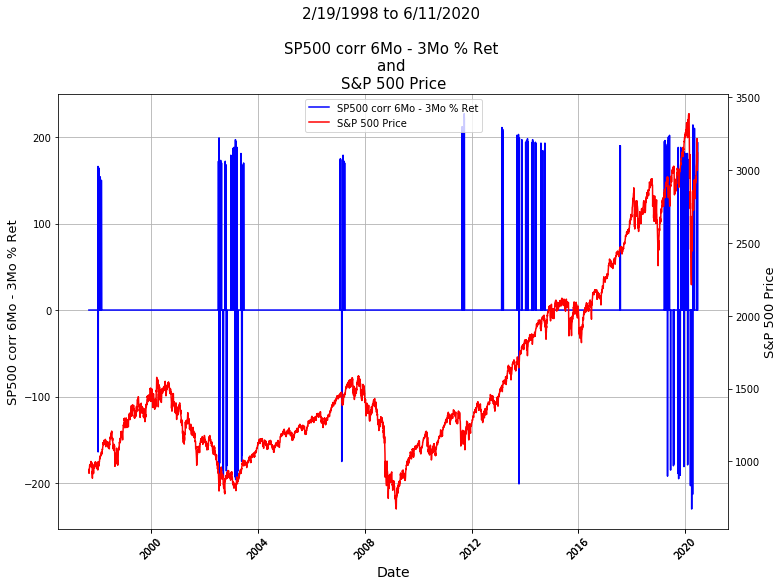

In [39]:
use_final_div_df = df_datefilter(final_div_df)
use_final_div_df.loc[(use_final_div_df["Div/6-3"] <= 150) & (use_final_div_df["Div/6-3"] >= -150), \
        "Div/6-3"] = 0
use_final_div_df = df_datefilter(use_final_div_df)
# use_final_div_df = df_datefilter(use_final_div_df, begin_date="2015-06-11")
# use_final_div_df = df_datefilter(use_final_div_df, end_date="2010-06-11")
# use_final_div_df = df_datefilter(use_final_div_df, begin_date="2016-02-19", end_date="2020-06-11")
use_final_div_df

fig8 = plt.figure(figsize=(12, 8))

ax1 = fig8.add_subplot(111)
line1 = ax1.plot(use_final_div_df["Date"], use_final_div_df["Div/6-3"], "b-")
plt.xticks(rotation=45)
plt.ylabel("SP500 corr 6Mo - 3Mo % Ret", size=13)
plt.grid(alpha=1)

ax2 = fig8.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(use_final_div_df["Date"], use_final_div_df["SP500"], "r-")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.xticks(rotation=45)
plt.ylabel("S&P 500 Price", size=13)


ax1.legend((line1+line2), ("SP500 corr 6Mo - 3Mo % Ret", "S&P 500 Price"), loc="upper center")
plt.title("2/19/1998 to 6/11/2020 \n\nSP500 corr 6Mo - 3Mo % Ret \nand \nS&P 500 Price", size=15)
plt.xlabel("Date", size=14)

plt.show()

fig8.tight_layout()